# 0.0 IMPORTS

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display  import HTML

## 0.1 Helper Function

In [67]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [68]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [119]:
aep = pd.read_csv( 'data/AEP_hourly.csv', low_memory=False )
comed = pd.read_csv( 'data/COMED_hourly.csv', low_memory=False )
dayton = pd.read_csv( 'data/DAYTON_hourly.csv', low_memory=False )
deok = pd.read_csv( 'data/DEOK_hourly.csv', low_memory=False )
dom = pd.read_csv( 'data/DOM_hourly.csv', low_memory=False )
duq = pd.read_csv( 'data/DUQ_hourly.csv', low_memory=False )
ekpc = pd.read_csv( 'data/EKPC_hourly.csv', low_memory=False )
fe = pd.read_csv( 'data/FE_hourly.csv', low_memory=False )
ni = pd.read_csv( 'data/NI_hourly.csv', low_memory=False )
pjm = pd.read_csv( 'data/PJM_Load_hourly.csv', low_memory=False )
pjme = pd.read_csv( 'data/PJME_hourly.csv', low_memory=False )
pjmw = pd.read_csv( 'data/PJMW_hourly.csv', low_memory=False )

In [120]:
# I will combine all the datasets into one. For this I will create a column in each of the datasets that will identify your respective electric company.

aep['electric_company'] = 'AEP'
comed['electric_company'] = 'COMED'
dayton['electric_company'] = 'DAYTON'
deok['electric_company'] = 'DEOK'
dom['electric_company'] = 'DOM'
duq['electric_company'] = 'DUQ'
ekpc['electric_company'] = 'EKPC'
fe['electric_company'] = 'FE'
ni['electric_company'] = 'NI'
pjm['electric_company'] = 'PJM'
pjme['electric_company'] = 'PJME'
pjmw['electric_company'] = 'PJMW'

In [121]:
# the column in each dataset that shows the Megawatt Energy Consumption, I will rename it with the same name in all.

aep = aep.rename( columns={'AEP_MW': 'mw_energy_consumption'} )
comed = comed.rename( columns={'COMED_MW': 'mw_energy_consumption'} )
dayton = dayton.rename( columns={'DAYTON_MW': 'mw_energy_consumption'} )
deok = deok.rename( columns={'DEOK_MW': 'mw_energy_consumption'} )
dom = dom.rename( columns={'DOM_MW': 'mw_energy_consumption'} )
duq = duq.rename( columns={'DUQ_MW': 'mw_energy_consumption'} )
ekpc = ekpc.rename( columns={'EKPC_MW': 'mw_energy_consumption'} )
fe = fe.rename( columns={'FE_MW': 'mw_energy_consumption'} )
ni = ni.rename( columns={'NI_MW': 'mw_energy_consumption'} )
pjm = pjm.rename( columns={'PJM_Load_MW': 'mw_energy_consumption'} )
pjme = pjme.rename( columns={'PJME_MW': 'mw_energy_consumption'} )
pjmw = pjmw.rename( columns={'PJMW_MW': 'mw_energy_consumption'} )

In [124]:
# Concatenate all the datasets
df_raw = pd.concat( [aep, comed, dayton, deok, dom, duq, ekpc, fe, ni, pjm, pjme, pjmw] )
df_raw.sample(5) # check

,Datetime,mw_energy_consumption,electric_company
77604,2013-05-25 09:00:00,12329.0,AEP
140369,2018-07-28 19:00:00,42174.0,PJME
120607,2018-01-28 05:00:00,1635.0,DAYTON
27429,2014-06-16 02:00:00,6428.0,FE
22043,2015-01-26 13:00:00,2016.0,EKPC


# 1.0 STEP 01 - DESCRIPTION OF DATA

In [126]:
# At the beginning of each step I will make a copy of the dataset to make it easier to reload the data in case there is a problem with the project.
df1 = df_raw.copy()

## 1.1 Rename Columns

In [127]:
# Although I already renamed some columns when I was preparing the datasets to concatenate them, I will check if there are any more columns that are not in the format I want them to be.
df1.columns

Index(['Datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

In [128]:
# Only the column "Datetime" don't have the format that I want.
cols_old = ['Datetime', 'mw_energy_consumption', 'electric_company']

# If the dataset had too many columns to change I would use the "snakecase" technique through the "inflection" function. Since this dataset has only one column to change the name, I will do this process manually.
cols_new = ['datetime', 'mw_energy_consumption', 'electric_company']

# rename
df1.columns = cols_new

In [129]:
df1.columns

Index(['datetime', 'mw_energy_consumption', 'electric_company'], dtype='object')

## 1.2 Data Dimensions

In [130]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 1090167
Number of Cols: 3


## 1.3 Data Types

In [131]:
df1.dtypes
# Observe datetime. It has a different data type.

datetime                  object
mw_energy_consumption    float64
electric_company          object
dtype: object

In [132]:
# function "datetime" transforma the columns "datetime" from object (string) to datetime.
df1['datetime'] = pd.to_datetime( df1['datetime'] )

In [133]:
df1.dtypes

datetime                 datetime64[ns]
mw_energy_consumption           float64
electric_company                 object
dtype: object

## 1.4 Check NA

In [134]:
df1.isna().sum()

datetime                 0
mw_energy_consumption    0
electric_company         0
dtype: int64

## 1.5 Fillout NA

In [135]:
# We don't have NA value to fillout... :)

## 1.6 Change Types

In [136]:
# We already did the change types.

## 1.7 Descriptive Statistical

In [137]:
# divide into numerical and categorical columns, as they will be treated with different techniques.
num_attributes = df1.select_dtypes( include=['float64'] )
cat_attributes = df1.select_dtypes( exclude=['float64', 'datetime64[ns]'] )

In [139]:
num_attributes.sample()

,mw_energy_consumption
4028,39569.0


In [140]:
cat_attributes.sample()

,electric_company
54163,FE


### 1.7.1 Numerical Attibutes

In [141]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [142]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,mw_energy_consumption,0.0,62009.0,62009.0,11209.58865,8217.0,10534.394704,1.356423,1.198281


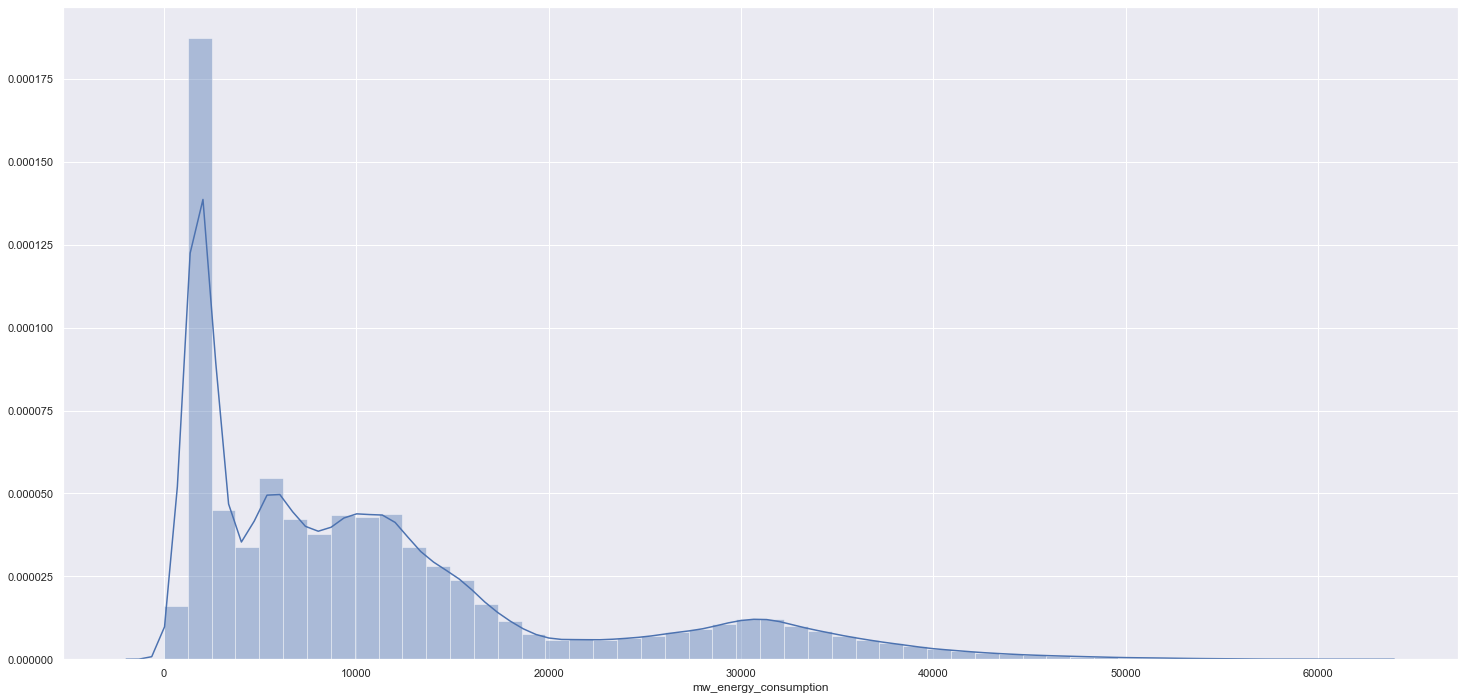

In [143]:
sns.distplot( df1['mw_energy_consumption'] )

### 1.7.2 Cetegorical Attibutes

In [145]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

electric_company    12
dtype: int64

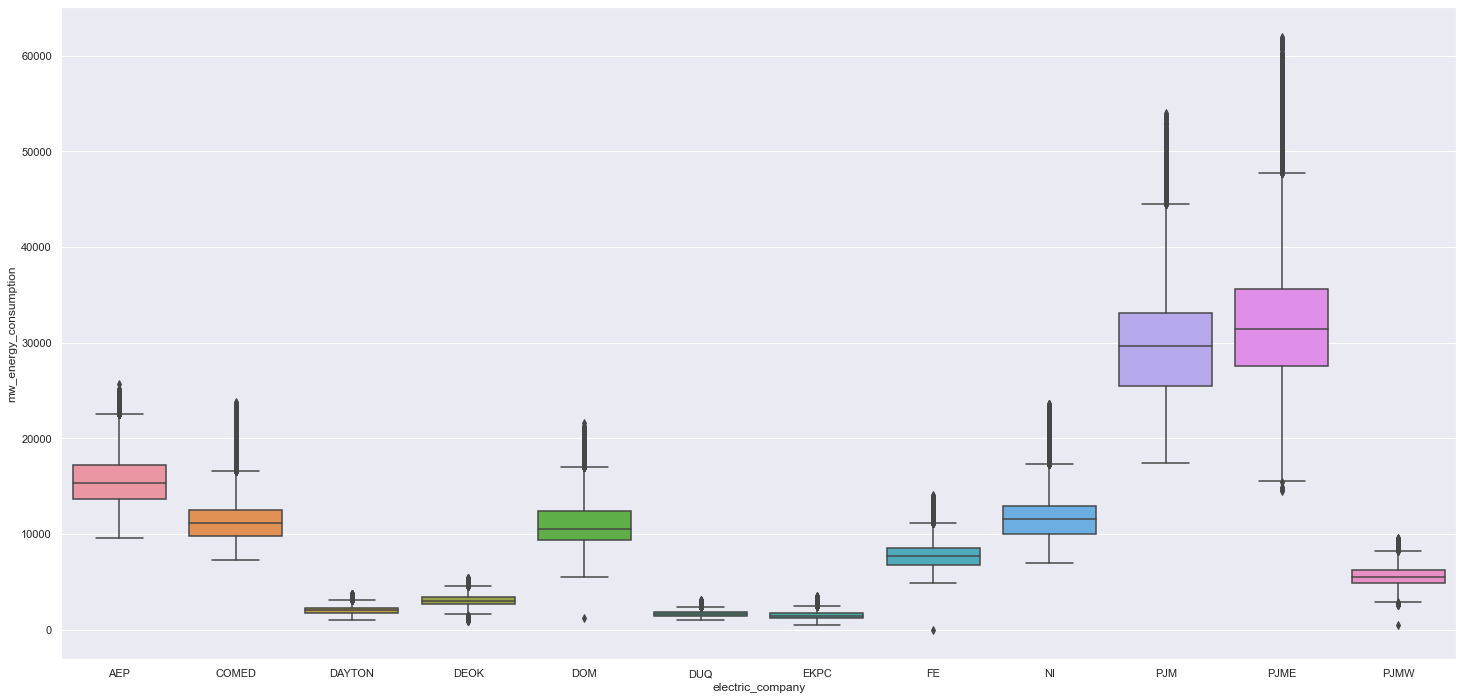

In [146]:
sns.boxplot( x= 'electric_company', y='mw_energy_consumption' , data=df1 )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [147]:
df2 = df1.copy()